<h1>Scraping KSL Classifieds for car data</h1>

We'll start by importing <a href="http://docs.python-requests.org/en/latest/">requests</a>, which allows us to make HTTP requests, and <a href="https://www.crummy.com/software/BeautifulSoup/bs4/doc/">BeautifulSoup</a>, which is an HTML parser. We'll grab the HTML from a page of the KSL listings for the Toyota Camry. The variable <b>soup</b> is a parsed object representing the entire web page. Below, we create <b>car_divs</b>, which is a list of parsed objects, each representing one car ad. We can search within each of these smaller soups to grab certain attributes from each ad.

In [98]:
import requests
from bs4 import BeautifulSoup

url = r"http://www.ksl.com/auto/search/index?keyword=&make%5B%5D=Toyota&model%5B%5D=Camry&yearFrom=&yearTo=&mileageFrom=&mileageTo=&priceFrom=&priceTo=&zip=&miles=25&newUsed%5B%5D=All&page=0&sellerType=&postedTime=&titleType=&body=&transmission=&cylinders=&liters=&fuel=&drive=&numberDoors=&exteriorCondition=&interiorCondition=&cx_navSource=hp_search&search.x=21&search.y=15&search=Search+raquo%3B"
cars_list = []
html = requests.get(url).text
soup = BeautifulSoup(html, 'html5lib')

car_divs = soup.find_all('div', {'class': 'srp-listing-body-right'})
for car in car_divs:
    cars_list.append(
        {
            'title': car.find('div', {'class': 'srp-listing-title'}).find('a').text.strip(),
            'price': car.find('div', {'class': 'srp-listing-price'}).text.strip(),
            'location-and-miles': car.find('div', {'class': 'srp-listing-city'}).text.strip()
        }
    )
    
cars_list[:5]

[{'location-and-miles': '31,885 Miles | Murray, UT | document.write(ts_to_age_min(1460445557));',
  'price': '$14,567',
  'title': '2012 Toyota Camry SE'},
 {'location-and-miles': '279,594 Miles | Salt Lake City, UT | document.write(ts_to_age_min(1460444597));',
  'price': '$4,000',
  'title': '2005 Toyota Camry LE'},
 {'location-and-miles': '42,998 Miles | West Valley City, UT | document.write(ts_to_age_min(1460443894));',
  'price': '$16,358',
  'title': '2014 Toyota Camry SE'},
 {'location-and-miles': '78,560 Miles | Orem, UT | document.write(ts_to_age_min(1460443154));',
  'price': '$12,689',
  'title': '2012 Toyota Camry LE'},
 {'location-and-miles': '62,581 Miles | Ogden, UT | document.write(ts_to_age_min(1460441762));',
  'price': '$16,900',
  'title': '2014 Toyota Camry SE'}]

<h1>Cleaning the Data</h1>

As you can see, the data in <b>cars_list</b> is pretty dirty. The prices are string values with dollar signs and commas and some extra information. City, state, and mileage are combined in one attribute. The 'title' attribute could also probably be broken into year, model, and make.

We'll use the <a href="http://pandas.pydata.org/pandas-docs/version/0.18.0/">pandas</a> library to clean our data. First, let's load our data into a DataFrame.

In [99]:
from pandas import DataFrame
import pandas as pd

df = DataFrame(cars_list)
df.head()

,location-and-miles,price,title
0,"31,885 Miles | Murray, UT | document.write(ts_...","$14,567",2012 Toyota Camry SE
1,"279,594 Miles | Salt Lake City, UT | document....","$4,000",2005 Toyota Camry LE
2,"42,998 Miles | West Valley City, UT | document...","$16,358",2014 Toyota Camry SE
3,"78,560 Miles | Orem, UT | document.write(ts_to...","$12,689",2012 Toyota Camry LE
4,"62,581 Miles | Ogden, UT | document.write(ts_t...","$16,900",2014 Toyota Camry SE


Using string functions, we could clean a single price value like so...

In [100]:
sample_price = prices[4]

print("orignal:", sample_price)

sample_price = sample_price.replace("MSRP", "").strip()
sample_price = sample_price.split()[0]
sample_price = int(sample_price.replace("$", "").replace(",", ""))

print("cleaned:", sample_price)

orignal: $21,280 | MSRP $24,324
cleaned: 21280


We certainly could loop through the entire list cleaning each row. However, pandas lets us easily apply a lambda function to an entire column:

In [101]:
import re

def clean_price(price):
    new_price = price.replace("MSRP", "").strip()
    new_price = new_price.split()[0]
    new_price = int(re.sub("[$,]", "", new_price))
    return new_price

df["price"] = df["price"].apply(clean_price)

df.head()

,location-and-miles,price,title
0,"31,885 Miles | Murray, UT | document.write(ts_...",14567,2012 Toyota Camry SE
1,"279,594 Miles | Salt Lake City, UT | document....",4000,2005 Toyota Camry LE
2,"42,998 Miles | West Valley City, UT | document...",16358,2014 Toyota Camry SE
3,"78,560 Miles | Orem, UT | document.write(ts_to...",12689,2012 Toyota Camry LE
4,"62,581 Miles | Ogden, UT | document.write(ts_t...",16900,2014 Toyota Camry SE


Let's do the same with the other columns.

In [102]:
def split_city_state_and_miles(cell):
    loc_and_mi = cell.split("|")
    mi = loc_and_mi[0].split()[0].replace(',', '').strip()
    loc = loc_and_mi[1].strip()
    city_and_state = loc.split(",")
    city = city_and_state[0].strip()
    state = city_and_state[1].strip()
    
    return [city, state, int(mi)]

temp_df = pd.DataFrame([x for x in df["location-and-miles"].apply(split_city_state_and_miles)],
                       columns=["city", "state", "miles"])

df = pd.merge(df, temp_df, left_index=True, right_index=True)

df.head()

,location-and-miles,price,title,city,state,miles
0,"31,885 Miles | Murray, UT | document.write(ts_...",14567,2012 Toyota Camry SE,Murray,UT,31885
1,"279,594 Miles | Salt Lake City, UT | document....",4000,2005 Toyota Camry LE,Salt Lake City,UT,279594
2,"42,998 Miles | West Valley City, UT | document...",16358,2014 Toyota Camry SE,West Valley City,UT,42998
3,"78,560 Miles | Orem, UT | document.write(ts_to...",12689,2012 Toyota Camry LE,Orem,UT,78560
4,"62,581 Miles | Ogden, UT | document.write(ts_t...",16900,2014 Toyota Camry SE,Ogden,UT,62581


In [104]:
def split_year_make_model(cell):
    split_cell = cell.split()
    year = split_cell[0]
    make = split_cell[1]
    model = " ".join(split_cell[2:])
    
    return [int(year), make, model]

temp_df = pd.DataFrame([x for x in df["title"].apply(split_year_make_model)],
                       columns=["year", "make", "model"])

df = pd.merge(df, temp_df, left_index=True, right_index=True)

df.head()

,location-and-miles,price,title,city,state,miles,year,make,model
0,"31,885 Miles | Murray, UT | document.write(ts_...",14567,2012 Toyota Camry SE,Murray,UT,31885,2012,Toyota,Camry SE
1,"279,594 Miles | Salt Lake City, UT | document....",4000,2005 Toyota Camry LE,Salt Lake City,UT,279594,2005,Toyota,Camry LE
2,"42,998 Miles | West Valley City, UT | document...",16358,2014 Toyota Camry SE,West Valley City,UT,42998,2014,Toyota,Camry SE
3,"78,560 Miles | Orem, UT | document.write(ts_to...",12689,2012 Toyota Camry LE,Orem,UT,78560,2012,Toyota,Camry LE
4,"62,581 Miles | Ogden, UT | document.write(ts_t...",16900,2014 Toyota Camry SE,Ogden,UT,62581,2014,Toyota,Camry SE


In [105]:
df.drop(['location-and-miles', 'title'], axis=1, inplace=True)

df.head()

,price,city,state,miles,year,make,model
0,14567,Murray,UT,31885,2012,Toyota,Camry SE
1,4000,Salt Lake City,UT,279594,2005,Toyota,Camry LE
2,16358,West Valley City,UT,42998,2014,Toyota,Camry SE
3,12689,Orem,UT,78560,2012,Toyota,Camry LE
4,16900,Ogden,UT,62581,2014,Toyota,Camry SE


Now we have the data in more or less atomic units (except perhaps model), and we're ready to play with it. First, let's save our data in CSV format.

In [139]:
df.to_csv("cars.csv")

<h1>Preliminary Statistics</h1>

Now, let's do some summary statistics and graph some frequency counts to see the shape of the string columns.

In [140]:
df.describe()

,price,year
count,18.000000,18.000000
mean,12785.277778,2009.888889
std,6840.168521,5.051370
min,700.000000,1998.000000
25%,8496.250000,2006.250000
50%,13628.000000,2011.500000
75%,16764.500000,2014.000000
max,25377.000000,2016.000000


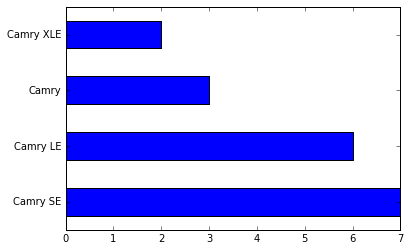

In [109]:
%matplotlib inline

df["city"].value_counts().plot(kind='barh', rot=0)

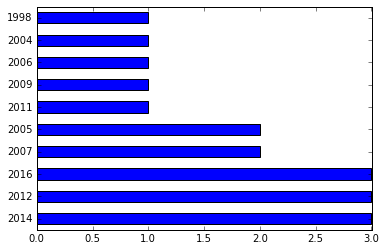

In [110]:
df["year"].value_counts().plot(kind='barh', rot=0)

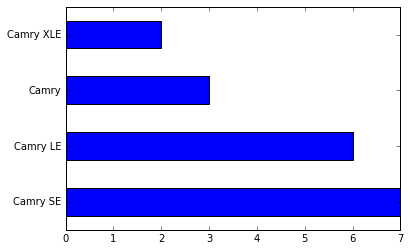

In [111]:
df["model"].value_counts().plot(kind='barh', rot=0)

And now, let's import <a href="http://scikit-learn.org/stable/">Scikit-Learn</a>, the premiere machine learning library in Python, and find a linear regression that uses 'miles' and 'year' to predict 'price' of the car.

In [138]:
from sklearn import linear_model
import numpy as np
from matplotlib import pyplot as plt

X = np.array(df[["miles", "year"]])
y = np.array(df["price"])

X_train = X[:10]
y_train = y[:10]

X_test = X[10:]
y_test = y[10:]

regressor = linear_model.LinearRegression()
regressor.fit(X_train, y_train)

prediction = regressor.predict(X_test)
score = regressor.score(X_test, y_test)

print("formula: y =", str(regressor.coef_[0]) + "*x1 + " + str(regressor.coef_[1]) + "*x2")
print("prediction:", prediction)
print("actual:", y_test)
print("score:", score)

formula: y = -0.0171143951793*x1 + 1119.25627644*x2
prediction: [ 14067.93290016  11064.16728123  -3817.92585647   5574.27803995
   8805.42551324   9216.17099754  15411.43909664  20350.55287225]
actual: [15400  8495   700  5250  9988 12500 14995 25377]
score: 0.828555279984


As you can see, our predictions are (mostly) decent, though we do predict a negative value for our outlier car with over 200,000 miles. Our R^2 is 0.83.